In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
all_data = pd.read_csv('all_data.csv', index_col=0)
PM25 = pd.read_csv('PM25.csv', index_col=0)
model_data = all_data = pd.concat([all_data, PM25], axis=1)
model_data = model_data.rename(columns={model_data.columns[-1]: "PM2.5"})
model_data = model_data.dropna(subset=["PM2.5"])
model_data

X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine"]]
y = model_data['PM2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.002,random_state=42)

In [2]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def objective(trial):
    X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine"]]
    y = model_data["PM2.5"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.002, random_state=42)

    n_estimators = trial.suggest_int('n_estimators', 1, 1500)
    max_depth = trial.suggest_int('max_depth', 1, 800)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                                      min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                      max_features=max_features, random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)

    return r2

study = optuna.create_study(direction='maximize')

improvement_threshold = 0.001
stale_count = 0

best_r2 = -float('inf')

r2_values = []

for _ in range(11000):
    study.optimize(objective, n_trials=1)

    if study.best_value > best_r2:
        best_r2 = study.best_value
        stale_count = 0
    else:
        stale_count += 1

    r2_values.append(best_r2)

    if stale_count >= 11000 or best_r2 >= 1.0:
        break

best_params = study.best_params
best_r2 = study.best_value

print("Najlepsze parametry:", best_params)
print("Najlepszy R^2 Score:", best_r2)


[I 2023-10-23 07:11:49,045] A new study created in memory with name: no-name-e7b0a28d-d5af-43df-b8c5-334474a504be
[I 2023-10-23 07:11:50,417] Trial 0 finished with value: 0.8251260618958189 and parameters: {'n_estimators': 186, 'max_depth': 792, 'min_samples_split': 6, 'min_samples_leaf': 47, 'max_features': 0.5076181005094486}. Best is trial 0 with value: 0.8251260618958189.
[I 2023-10-23 07:12:02,244] Trial 1 finished with value: 0.7879720782612778 and parameters: {'n_estimators': 824, 'max_depth': 589, 'min_samples_split': 38, 'min_samples_leaf': 12, 'max_features': 0.4184372663648931}. Best is trial 0 with value: 0.8251260618958189.
[I 2023-10-23 07:12:11,321] Trial 2 finished with value: 0.7951179659362879 and parameters: {'n_estimators': 1081, 'max_depth': 22, 'min_samples_split': 26, 'min_samples_leaf': 13, 'max_features': 0.20684971739216362}. Best is trial 0 with value: 0.8251260618958189.
[I 2023-10-23 07:12:13,844] Trial 3 finished with value: 0.7956625493469216 and paramete

KeyboardInterrupt: 

Średni błąd kwadratowy (MSE): 31.724717876947977
Procentowa zgodność: 94.96%


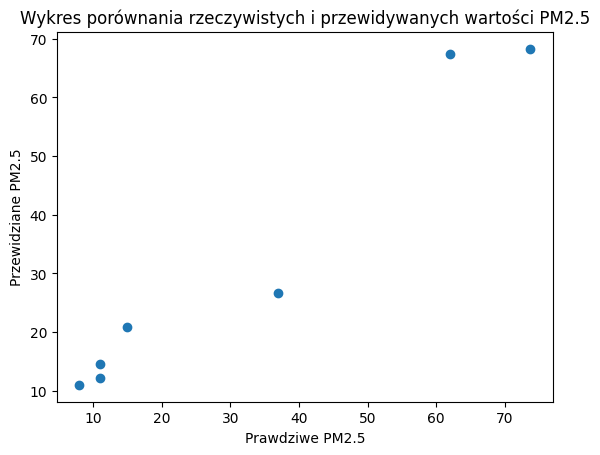

,Rzeczywiste wartości (y_test),Przewidywane wartości (y_pred),Różnica
194,11.00,14.602326,-3.602326
2194,10.98,12.134960,-1.154960
3276,73.73,68.258562,5.471438
199,15.00,20.814218,-5.814218
1091,8.00,10.973058,-2.973058
80,37.00,26.667078,10.332922
2602,62.02,67.350311,-5.330311


In [4]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


params =  {'n_estimators': 407, 'max_depth': 33, 'min_samples_split': 36, 'min_samples_leaf': 17, 'max_features': 0.9614909270469754}
X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine"]]
y = model_data["PM2.5"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.002, random_state=42)


model = GradientBoostingRegressor(**params,random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"Procentowa zgodność: {percent_match:.2f}%")

plt.scatter(y_test, y_pred)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()

results = pd.DataFrame({'Rzeczywiste wartości (y_test)': y_test, 'Przewidywane wartości (y_pred)': y_pred})
results['Różnica'] = results['Rzeczywiste wartości (y_test)'] - results['Przewidywane wartości (y_pred)']
results



